# Quantum Teleportation

This notebook demonstrates quantum teleportation. We first use Qiskit's built-in simulator to test our quantum circuit, and then try it out on a real quantum computer.

## The concept

Alice wants to send quantum information to Bob. Specifically, suppose she wants to send the state
$\vert\psi\rangle = \alpha\vert0\rangle + \beta\vert1\rangle$
to Bob. This entails passing on information about $\alpha$ and $\beta$ to Bob.

There exists a theorem in quantum mechanics which states that you cannot simply make an exact copy of an unknown quantum state. This is known as the no-cloning theorem. As a result of this we can see that Alice can't simply generate a copy of $\vert\psi\rangle$ and give the copy to Bob. Copying a state is only possible with a classical computation.

However, by taking advantage of two classical bits and entanglement, Alice can transfer the state $\vert\psi\rangle$ to Bob. We call this teleportation as at the end Bob will have $\vert\psi\rangle$ and Alice won't anymore. Let's see how this works in some detail.

## How does quantum teleportation work?

<img src="images/teleport_theory.png" width="800 px" align="left">

**Step 1**: Alice and Bob create an entangled pair of qubits and each one of them holds on to one of the two qubits in the pair.

**Step 2**: Alice applies a CNOT gate on her entangled qubit, controlled by the qubit she is trying to send Bob. 

**Step 3**: Next, Alice applies a Hadamard gate to the qubit she is trying to send Bob, and applies a measurement to both qubits that she owns.

**Step 4**: Then, it's time for a phone call to Bob. She tells Bob the outcome of her two qubit measurement. Depending on what she says, Bob applies some gates to his entangled qubit, $q_2$. The gates to be applied, based on what Alice says, are as follows :

00 $\rightarrow$ Do nothing

01 $\rightarrow$ Apply $X$ gate

10 $\rightarrow$ Apply $Z$ gate

11 $\rightarrow$ Apply $ZX$ gate

*Note that this transfer of information is classical.*

And voila! At the end of this protocol, Alice's qubit has now teleported to Bob.

## 1. Simulating the teleportation protocol

In [1]:
# make the imports that are necessary for our work
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector
%matplotlib inline

Do to hardware and measurments constraints we need to implement a slightly modyfied version of the teleportation protocoll to be able to run it on a real QPU. The circuit we will build in this example looks like that

<img src="images/teleport_praxis.png" width="800 px" align="left">

In [2]:
# Create a Quantum Circuit acting on the quantum and classical register
q = QuantumRegister(3)
c = ClassicalRegister(3)
qc = QuantumCircuit(q, c)

For this example let us assume that the state Alice likes to teleport to Bob has been generated by applying a Hadamard gate followed by a Z-gate.

In [3]:
# Alice prepares the state she wants to send to Bob
qc.h(q[0])
qc.z(q[0])
qc.barrier()

In [4]:
#from utils.libquantum import print_sv
#from utils.libqiskit import get_statevector_for_circuit
#print_sv(get_statevector_for_circuit(qc))

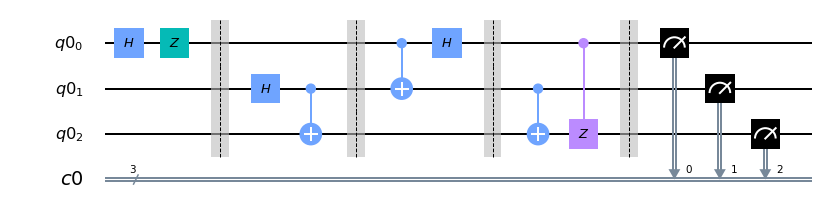

In [5]:
# Next, generate the entangled pair between Alice and Bob 
qc.h(q[1])
qc.cx(q[1], q[2])
qc.barrier()

# Alice prepares her qubits 
qc.cx(q[0], q[1])
qc.h(q[0])
qc.barrier()

# Bob applies final gates according to alice qubits and measures his qubit
qc.cx(q[1], q[2])
qc.cz(q[0], q[2])
qc.barrier()
qc.measure(q, c)

qc.draw(output='mpl')

{'101': 128, '111': 120, '000': 116, '001': 140, '010': 117, '011': 145, '110': 124, '100': 134}


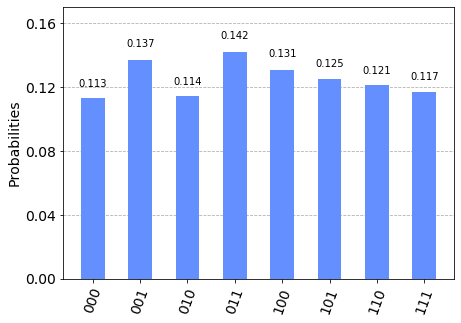

In [6]:
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots=1024)
sim_result = job_sim.result()

measurement_result = sim_result.get_counts(qc)
print(measurement_result)
plot_histogram(measurement_result)

## How will we test this result on a real quantum computer?

If the quantum teleportation circuit works, then at the output of the protocol discussed above will be the same state passed on to Alice. Then, looking at the measurement results that Bob obtains on his qubit we find

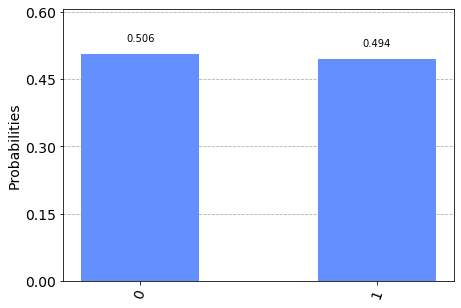

In [7]:
# only hava a look at Bob's measaurement results
bobs_qubit = {
    '0': sum([v for k,v in measurement_result.items() if k.startswith('0')]),
    '1': sum([v for k,v in measurement_result.items() if k.startswith('1')])
}
plot_histogram(bobs_qubit)

We see that Bob's qubit is not longer in the state $|0\rangle$ but in an equal superpostion state which Alice prepared. 

Another way to test our algorithm is to undo the applied secret unitary (by applying its conjugate transpose), to yield the $\vert0\rangle$ that we started with. 

We will then do repeated measurements of Bob's qubit to see how many times it gives 0 and how many times it gives 1.

In [8]:
# remove the last measurement gate from the quantum circuit
qc.data.pop(-1)

(<qiskit.circuit.measure.Measure at 0x7f0e2c79d4a8>,
 [Qubit(QuantumRegister(3, 'q0'), 2)],
 [Clbit(ClassicalRegister(3, 'c0'), 2)])

In [9]:
# add reverse secret unitary and measurment
qc.z(q[2])
qc.h(q[2])
qc.measure(q[2], c[2])

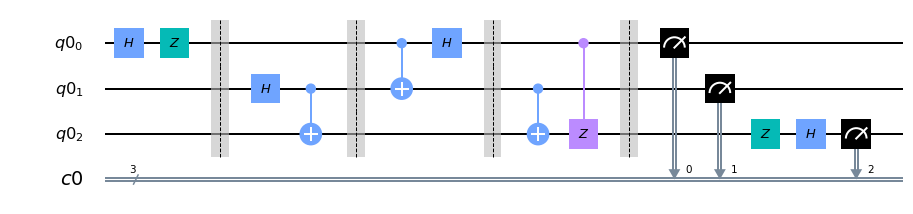

In [10]:
qc.draw(output='mpl')

{'011': 249, '001': 259, '000': 256, '010': 260}


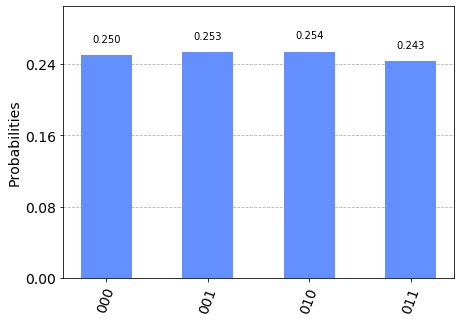

In [11]:
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend, shots=1024)
sim_result = job_sim.result()

measurement_result = sim_result.get_counts(qc)
print(measurement_result)
plot_histogram(measurement_result)

**Note that the results on the x-axis in the histogram above are ordered as $c_2c_1c_0$. We can see that only results where $c_2 = 0$ appear, indicating that the teleporation protocol has worked.**

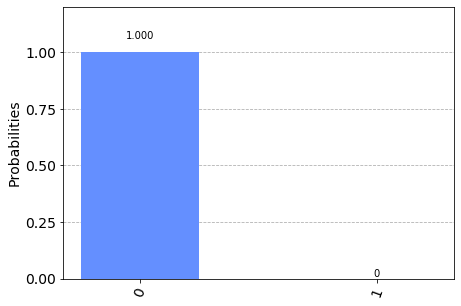

In [12]:
# only hava a look at Bob's measaurement results
bobs_qubit = {
    '0': sum([v for k,v in measurement_result.items() if k.startswith('0')]),
    '1': sum([v for k,v in measurement_result.items() if k.startswith('1')])
}
plot_histogram(bobs_qubit)

## 2. Teleportation on a real quantum computer

In [13]:
# First, see what devices we are allowed to use by loading our saved accounts
from qiskit import IBMQ
MY_TOKEN = '916a57af3175bd744bd9e8ad34bd84369e96a702dc28af96e9153a85c82bbcb03535532e388d00151b3042b5425f1dd9075a6d32ca5a09d1738e42e401e6e76f'
IBMQ.enable_account(token=MY_TOKEN)
provider = IBMQ.get_provider(hub='ibm-q')

/opt/conda/lib/python3.7/site-packages/qiskit/providers/models/backendconfiguration.py:337: UserWarning: `dt` and `dtm` now have units of seconds(s) rather than nanoseconds(ns).
  warnings.warn('`dt` and `dtm` now have units of seconds(s) rather '


In [14]:
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(simulator=False, n_qubits=5))

In [15]:
from qiskit.tools.monitor import job_monitor
job_exp = execute(qc, backend=backend, shots=8192)
job_monitor(job_exp)

Job Status: job has successfully run


{'101': 558, '111': 754, '000': 1433, '001': 1553, '010': 1376, '011': 1407, '110': 620, '100': 491}


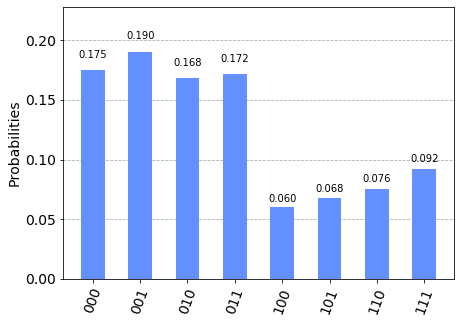

In [16]:
exp_result = job_exp.result()
exp_measurement_result = exp_result.get_counts(qc)
print(exp_measurement_result)
plot_histogram(exp_measurement_result)

**As we see here, there are a few results that contain the case when $c_2 = 1$ in a real quantum computer. These arise due to errors in the gates that were applied. Another source of error is the way we're checking for teleportation - we need the series of operators on $q_2$ to be exactly the inverse unitary of those that we applied to $q_0$ at the beginning.**

In contrast, our simulator in the earlier part of the notebook had zero errors in its gates, and allowed error-free teleportation.

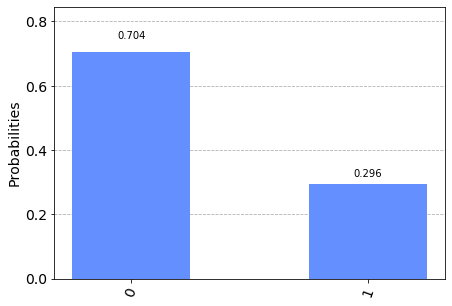

In [17]:
# only hava a look at Bob's measaurement results
bobs_qubit = {
    '0': sum([v for k,v in exp_measurement_result.items() if k.startswith('0')]),
    '1': sum([v for k,v in exp_measurement_result.items() if k.startswith('1')])
}
plot_histogram(bobs_qubit)

In [18]:
error_rate_percent = bobs_qubit['1']/(bobs_qubit['1']+bobs_qubit['0'])*100
print("The experimental error rate : ", error_rate_percent, "%")

The experimental error rate :  29.57763671875 %
